In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
data_path = "C:\\Users\\serdi\\Desktop\\Flood_Detection_Final_Project"
class_names = ["Flood", "Not_Flood"]
X, y = [], []

for class_name in class_names:
    class_path = os.path.join(data_path, class_name)
    for image_path in os.listdir(class_path):
        try:
            img = load_img(os.path.join(class_path, image_path), target_size=(224, 224))
            img_array = img_to_array(img)
            X.append(img_array)
            y.append(0 if class_name == "Flood" else 1)
        except UnidentifiedImageError:
            print(f"Invalid image file: {os.path.join(class_path, image_path)}")

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)




In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,
    channel_shift_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]  # yeni bir veri artırma yöntemi
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Düğüm sayısını 1024'e çıkardık
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

steps_per_epoch = len(X_train)// 32
validation_steps = len(X_val)// 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_weights.h5',
    monitor='val_loss',
    save_best_only=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/30
104/104 [==============================] - 587s 6s/step - loss: 0.6145 - accuracy: 0.6994 - val_loss: 0.4879 - val_accuracy: 0.7537
Epoch 2/30
104/104 [==============================] - 600s 6s/step - loss: 0.4615 - accuracy: 0.7874 - val_loss: 0.3155 - val_accuracy: 0.8575
Epoch 3/30
104/104 [==============================] - 598s 6s/step - loss: 0.3857 - accuracy: 0.8301 - val_loss: 0.2955 - val_accuracy: 0.8695
Epoch 4/30
104/104 [==============================] - 589s 6s/step - loss: 0.3999 - accuracy: 0.8144 - val_loss: 0.2793 - val_accuracy: 0.8860
Epoch 5/30
104/104 [==============================] - 592s 6s/step - loss: 0.3622 - accuracy: 0.8383 - val_loss: 0.3011 - val_accuracy: 0.8695
Epoch 6/30
104/104 [==============================] - 595s 6s/step - loss: 0.3647 - accuracy: 0.8405 - val_loss: 0.3143 - val_accuracy: 0.8539
Epoch 7/30
104/104 [==============================] - 580s 6s/step - loss: 0.3526 - accuracy: 0.8408 - val_loss: 0.3126 - val_accuracy: 0.8621

In [6]:

test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=True)
y_pred_probs = model.predict(test_generator, steps=len(X_test) // 32)
y_pred = np.where(y_pred_probs > 0.5, 1, 0)

test_acc = accuracy_score(y_test[:len(y_pred)], y_pred)
test_recall = recall_score(y_test[:len(y_pred)], y_pred)
test_f1 = f1_score(y_test[:len(y_pred)], y_pred)
conf_matrix = confusion_matrix(y_test[:len(y_pred)], y_pred)

print("Test Accuracy: {:.2f}%".format(test_acc * 100))
print("Recall: {:.2f}".format(test_recall))
print("F1 Score: {:.2f}".format(test_f1))
print("Confusion Matrix:\n", conf_matrix)

Test Accuracy: 48.62%
Recall: 0.46
F1 Score: 0.44
Confusion Matrix:
 [[307 303]
 [256 222]]


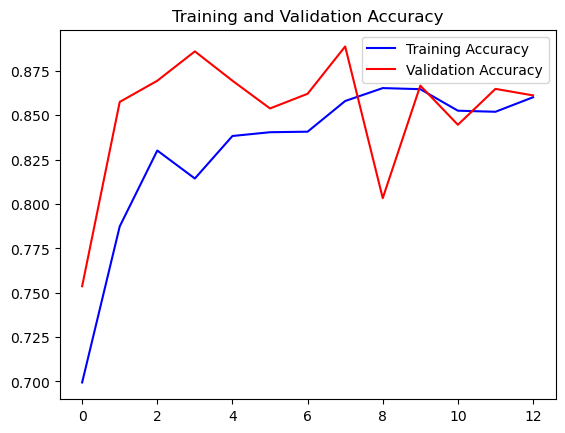

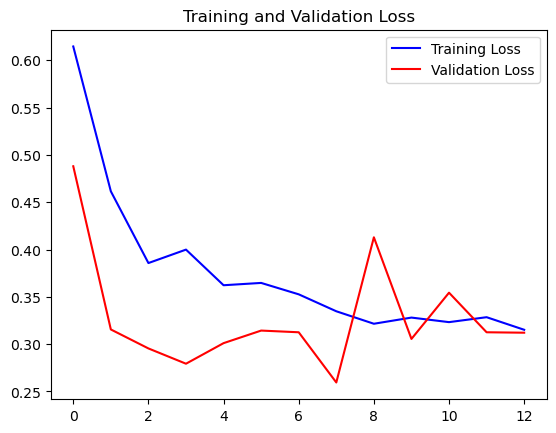

In [7]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_training_history(history)

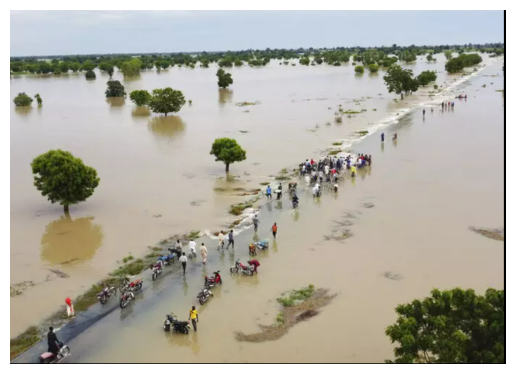

Prediction: Not Flood
Value: 0.0163


In [10]:
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

def predict_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    preds = model.predict(x)
    return preds[0][0]

new_image_path = "flo.png"
prediction = predict_image(new_image_path)

# Test edilen resmi gösterme
img = load_img(new_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

if prediction > 0.5:
    print("Prediction: Flood")
else:
    print("Prediction: Not Flood")

print("Value: {:.4f}".format(prediction))